# **Setup**

In [1]:
# If your dataset.zip is in your local machine, upload it
from google.colab import files
uploaded = files.upload()  # Choose dataset.zip

import zipfile
import os

if "dataset.zip" in uploaded:
    with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Dataset extracted!")


Saving dataset.zip to dataset.zip
Dataset extracted!


# **Install wandb**

In [2]:
!pip install wandb --quiet
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: soumoofficial2004 (soumoofficial2004-techno-institute-of-engineering-and-ma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# **Imports and Color Map**

In [3]:
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Dynamically build COLOR_MAP from dataset
def build_color_map(root_dir):
    colors = set()
    for split in ["training", "validation"]:
        json_file = os.path.join(root_dir, split, "data.json")
        with open(json_file, "r") as f:
            data = json.load(f)
        for entry in data:
            colors.add(entry["colour"].lower())
    color_list = sorted(list(colors))
    color_map = {color: idx for idx, color in enumerate(color_list)}
    return color_map

# Automatically detect all colors
DATASET_ROOT = "dataset"
COLOR_MAP = build_color_map(DATASET_ROOT)
NUM_COLORS = len(COLOR_MAP)
print("Detected colors:", COLOR_MAP)


Detected colors: {'blue': 0, 'cyan': 1, 'green': 2, 'magenta': 3, 'orange': 4, 'purple': 5, 'red': 6, 'yellow': 7}


# **Dataset Class**

In [4]:
# Dataset for image-only version
class PolygonDataset(Dataset):
    def __init__(self, root_dir, split="training", transform=None):
        self.inputs_dir = os.path.join(root_dir, split, "inputs")
        self.outputs_dir = os.path.join(root_dir, split, "outputs")
        self.json_file = os.path.join(root_dir, split, "data.json")
        self.transform = transform

        with open(self.json_file, "r") as f:
            self.data_list = json.load(f)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        entry = self.data_list[idx]
        input_path = os.path.join(self.inputs_dir, entry["input_polygon"])
        output_path = os.path.join(self.outputs_dir, entry["output_image"])

        inp = np.array(Image.open(input_path).convert("RGB"), dtype=np.float32) / 255.0
        out = np.array(Image.open(output_path).convert("RGB"), dtype=np.float32) / 255.0

        inp = torch.from_numpy(inp).permute(2, 0, 1)
        out = torch.from_numpy(out).permute(2, 0, 1)

        if self.transform:
            inp = self.transform(inp)
            out = self.transform(out)

        return inp, out


# Dataset for color-conditioned version
class PolygonDatasetWithColor(Dataset):
    def __init__(self, root_dir, split="training", transform=None):
        self.inputs_dir = os.path.join(root_dir, split, "inputs")
        self.outputs_dir = os.path.join(root_dir, split, "outputs")
        self.json_file = os.path.join(root_dir, split, "data.json")
        self.transform = transform

        with open(self.json_file, "r") as f:
            self.data_list = json.load(f)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        entry = self.data_list[idx]
        input_path = os.path.join(self.inputs_dir, entry["input_polygon"])
        output_path = os.path.join(self.outputs_dir, entry["output_image"])
        color_name = entry["colour"].lower()

        inp = np.array(Image.open(input_path).convert("RGB"), dtype=np.float32) / 255.0
        out = np.array(Image.open(output_path).convert("RGB"), dtype=np.float32) / 255.0

        inp = torch.from_numpy(inp).permute(2, 0, 1)
        out = torch.from_numpy(out).permute(2, 0, 1)

        color_idx = COLOR_MAP[color_name]
        color_onehot = torch.zeros(NUM_COLORS)
        color_onehot[color_idx] = 1.0

        if self.transform:
            inp = self.transform(inp)
            out = self.transform(out)

        return inp, color_onehot, out


# **UNet Architecture**

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.dconv_down1 = DoubleConv(in_channels, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out


class UNetWithColor(UNet):
    def __init__(self, in_channels=3, out_channels=3, num_colors=NUM_COLORS):
        super().__init__(in_channels=in_channels + num_colors, out_channels=out_channels)
        self.num_colors = num_colors

    def forward(self, x, color_vec):
        B, _, H, W = x.shape
        color_expanded = color_vec.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, H, W)
        x = torch.cat([x, color_expanded], dim=1)
        return super().forward(x)


# **Training + Visualization**

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_val = val_loss / len(val_loader)
        wandb.log({"train_loss": avg_train, "val_loss": avg_val})
        print(f"Epoch {epoch+1}/{num_epochs} - Train: {avg_train:.4f} - Val: {avg_val:.4f}")

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with val loss {best_val_loss:.4f}")


def train_model_conditioned(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, color_vecs, targets in train_loader:
            inputs, color_vecs, targets = inputs.to(device), color_vecs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, color_vecs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, color_vecs, targets in val_loader:
                inputs, color_vecs, targets = inputs.to(device), color_vecs.to(device), targets.to(device)
                outputs = model(inputs, color_vecs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_val = val_loss / len(val_loader)
        wandb.log({"train_loss": avg_train, "val_loss": avg_val})
        print(f"Epoch {epoch+1}/{num_epochs} - Train: {avg_train:.4f} - Val: {avg_val:.4f}")

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with val loss {best_val_loss:.4f}")


def visualize_results(model, dataset, device, num_images=5, conditioned=False):
    model.eval()
    plt.figure(figsize=(10, num_images * 3))
    with torch.no_grad():
        for i in range(num_images):
            if conditioned:
                inp, color_vec, tgt = dataset[i]
                inp_batch = inp.unsqueeze(0).to(device)
                color_batch = color_vec.unsqueeze(0).to(device)
                out = model(inp_batch, color_batch)
            else:
                inp, tgt = dataset[i]
                inp_batch = inp.unsqueeze(0).to(device)
                out = model(inp_batch)

            out = torch.sigmoid(out).cpu().squeeze(0)

            inp_np = inp.permute(1,2,0).numpy()
            tgt_np = tgt.permute(1,2,0).numpy()
            out_np = np.clip(out.permute(1,2,0).numpy(), 0, 1)

            plt.subplot(num_images, 3, i*3+1); plt.imshow(inp_np); plt.title("Input"); plt.axis('off')
            plt.subplot(num_images, 3, i*3+2); plt.imshow(tgt_np); plt.title("Target"); plt.axis('off')
            plt.subplot(num_images, 3, i*3+3); plt.imshow(out_np); plt.title("Predicted"); plt.axis('off')
    plt.tight_layout(); plt.show()


# **Train Image-only UNet**

Epoch 1/20 - Train: 0.4533 - Val: 0.5081
Model saved with val loss 0.5081
Epoch 2/20 - Train: 0.1337 - Val: 0.1694
Model saved with val loss 0.1694
Epoch 3/20 - Train: 0.0692 - Val: 0.0845
Model saved with val loss 0.0845
Epoch 4/20 - Train: 0.0549 - Val: 0.0605
Model saved with val loss 0.0605
Epoch 5/20 - Train: 0.0540 - Val: 0.0630
Epoch 6/20 - Train: 0.0494 - Val: 0.0578
Model saved with val loss 0.0578
Epoch 7/20 - Train: 0.0476 - Val: 0.0454
Model saved with val loss 0.0454
Epoch 8/20 - Train: 0.0458 - Val: 0.0399
Model saved with val loss 0.0399
Epoch 9/20 - Train: 0.0452 - Val: 0.0386
Model saved with val loss 0.0386
Epoch 10/20 - Train: 0.0450 - Val: 0.0394
Epoch 11/20 - Train: 0.0447 - Val: 0.0376
Model saved with val loss 0.0376
Epoch 12/20 - Train: 0.0437 - Val: 0.0386
Epoch 13/20 - Train: 0.0454 - Val: 0.0386
Epoch 14/20 - Train: 0.0451 - Val: 0.0378
Epoch 15/20 - Train: 0.0444 - Val: 0.0373
Model saved with val loss 0.0373
Epoch 16/20 - Train: 0.0447 - Val: 0.0379
Epoch 1

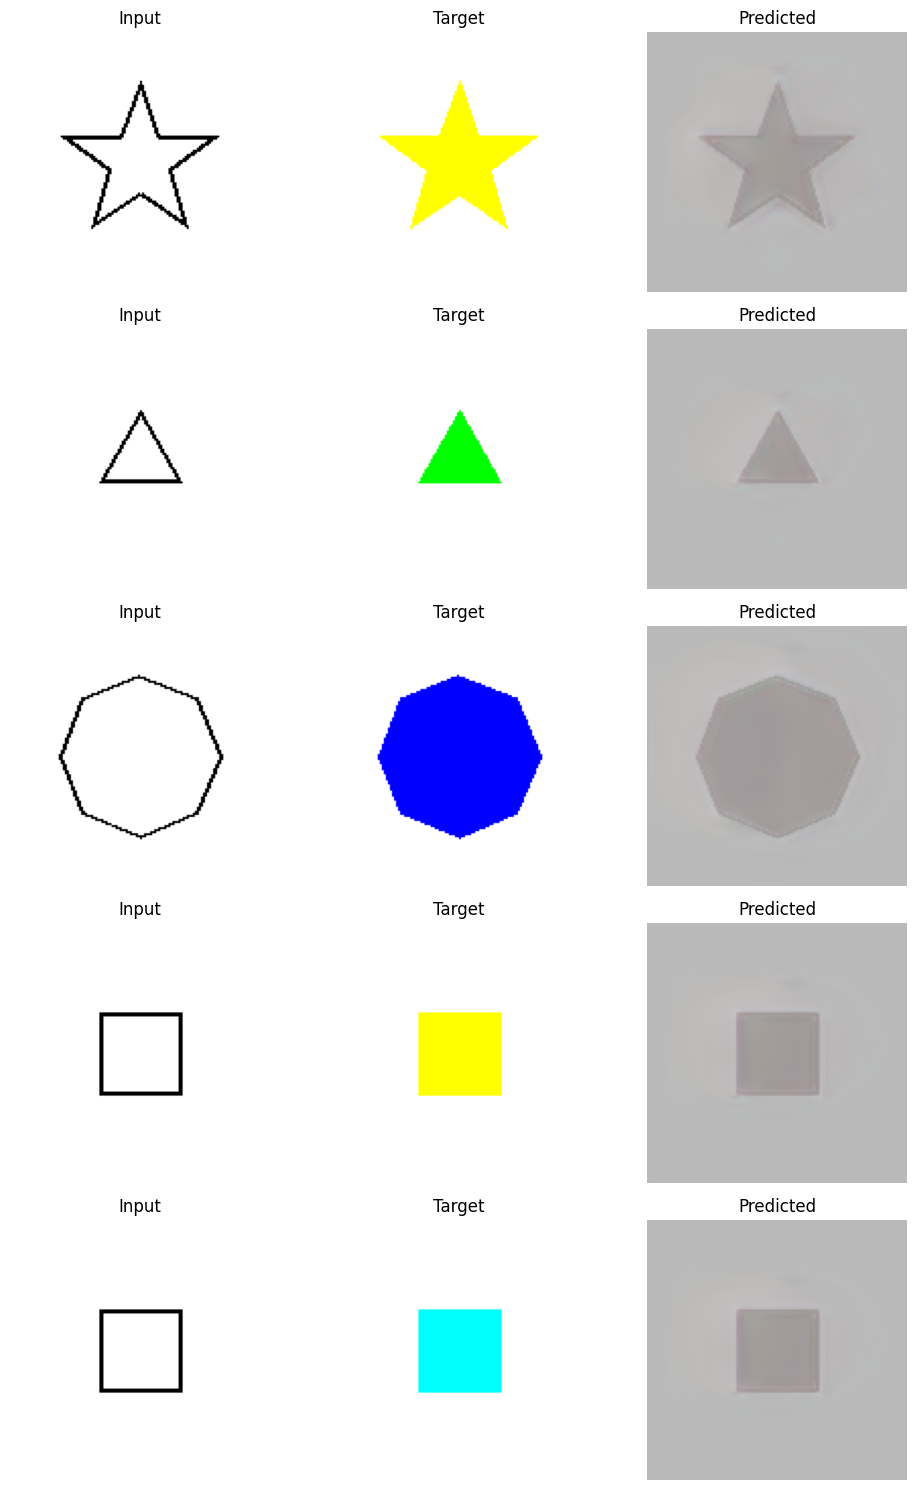

In [7]:
wandb.init(project="polygon_unet_assignment_imgonly")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path_img = "unet_imgonly.pth"
batch_size = 8
num_epochs = 20
lr = 1e-3

train_dataset = PolygonDataset("dataset", "training")
val_dataset = PolygonDataset("dataset", "validation")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = UNet(in_channels=3, out_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path_img)

model.load_state_dict(torch.load(save_path_img))
visualize_results(model, val_dataset, device, num_images=5, conditioned=False)


# **Train Color-conditioned UNet**

train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.0438
val_loss,0.03784


Epoch 1/20 - Train: 0.8783 - Val: 0.8248
Model saved with val loss 0.8248
Epoch 2/20 - Train: 0.4740 - Val: 0.5196
Model saved with val loss 0.5196
Epoch 3/20 - Train: 0.3054 - Val: 0.3151
Model saved with val loss 0.3151
Epoch 4/20 - Train: 0.1707 - Val: 0.2261
Model saved with val loss 0.2261
Epoch 5/20 - Train: 0.1149 - Val: 0.0994
Model saved with val loss 0.0994
Epoch 6/20 - Train: 0.0909 - Val: 0.0906
Model saved with val loss 0.0906
Epoch 7/20 - Train: 0.0744 - Val: 0.0695
Model saved with val loss 0.0695
Epoch 8/20 - Train: 0.0754 - Val: 0.0687
Model saved with val loss 0.0687
Epoch 9/20 - Train: 0.0744 - Val: 0.0547
Model saved with val loss 0.0547
Epoch 10/20 - Train: 0.0658 - Val: 0.0626
Epoch 11/20 - Train: 0.0623 - Val: 0.0665
Epoch 12/20 - Train: 0.0600 - Val: 0.0368
Model saved with val loss 0.0368
Epoch 13/20 - Train: 0.0428 - Val: 0.0257
Model saved with val loss 0.0257
Epoch 14/20 - Train: 0.0365 - Val: 0.0316
Epoch 15/20 - Train: 0.0306 - Val: 0.0219
Model saved with

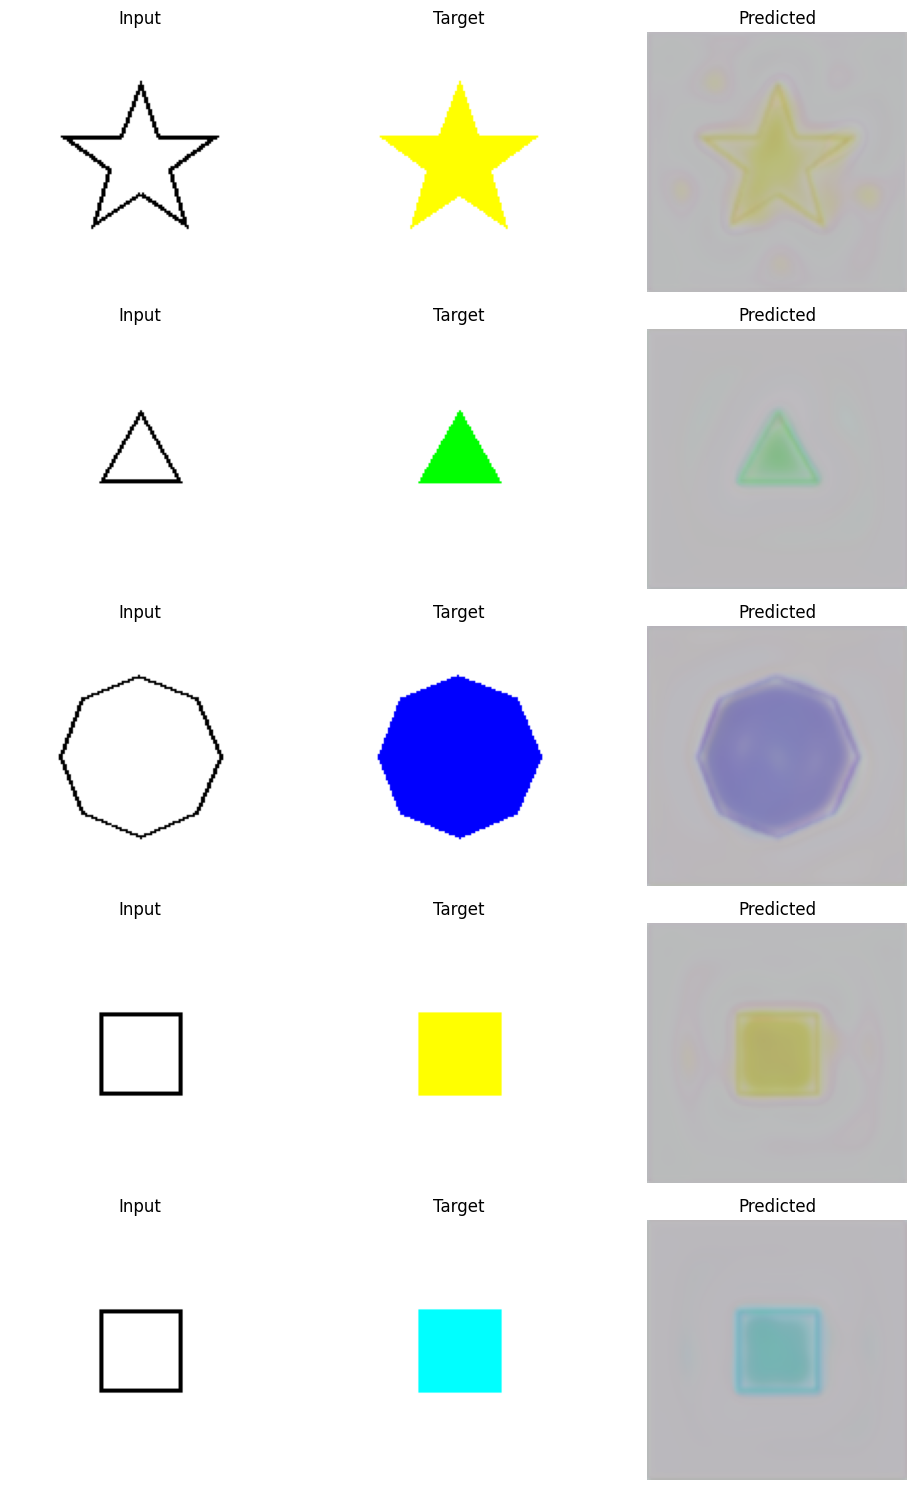

In [8]:
wandb.init(project="polygon_unet_assignment_conditioned")

save_path_cond = "unet_conditioned.pth"

train_dataset_cond = PolygonDatasetWithColor("dataset", "training")
val_dataset_cond = PolygonDatasetWithColor("dataset", "validation")
train_loader = DataLoader(train_dataset_cond, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_cond, batch_size=batch_size)

model_cond = UNetWithColor(in_channels=3, out_channels=3).to(device)
optimizer = optim.Adam(model_cond.parameters(), lr=lr)

train_model_conditioned(model_cond, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path_cond)

model_cond.load_state_dict(torch.load(save_path_cond))
visualize_results(model_cond, val_dataset_cond, device, num_images=5, conditioned=True)
